In [53]:
import json
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
from PIL import Image
import scipy.signal as signal
import time
from joblib import Parallel, delayed

In [54]:
#Loading data functions
def load_json(group,student):
    with open(f'./data/all_json/{group}_{student}.json') as f:
        return json.load(f)
    
def load_images(group,student):
    return imageio.imread(f'../../{group}-{student}.nosync.tif')

In [55]:
images = load_images(9,3)
images_mean = np.mean(images,axis=3)

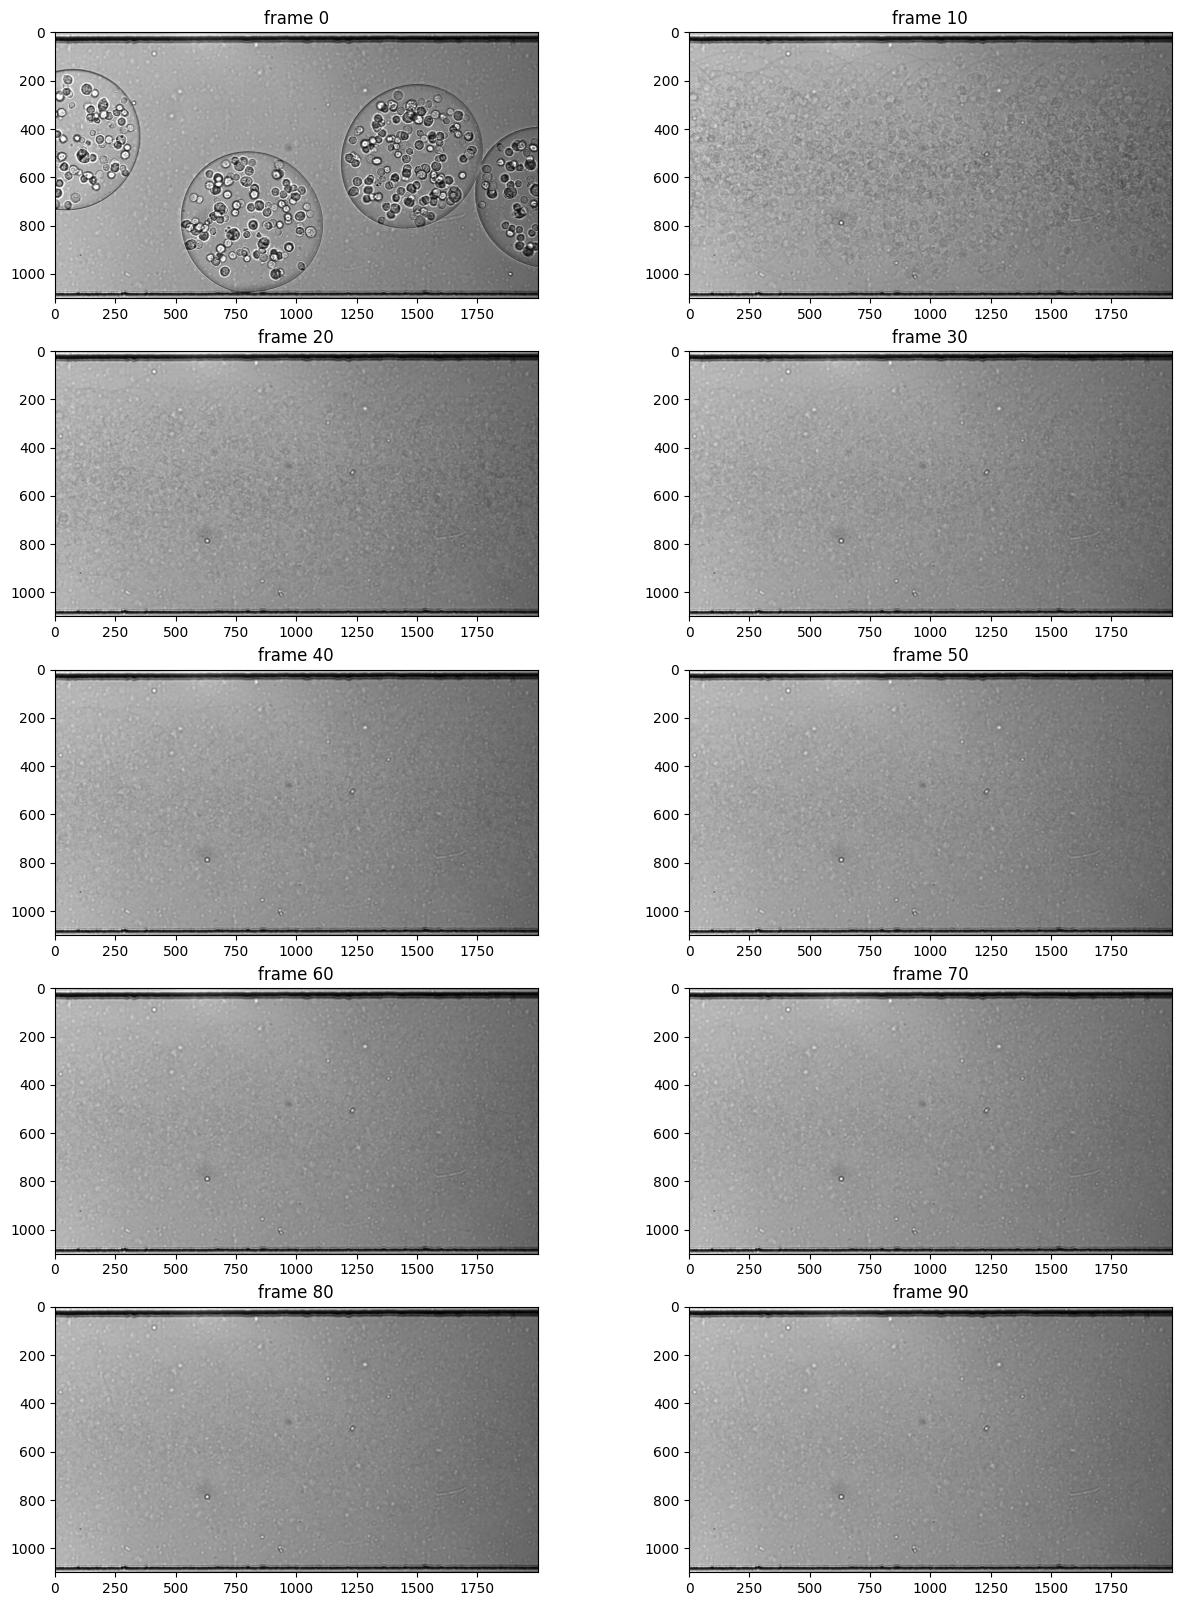

In [56]:
# Background frame by averaging i.e. naive method

background = np.zeros((10,images.shape[1],images.shape[2]))
background[0] = np.mean(images_mean[:1],axis=(0))

for i in range(1,10):
    background[i] = np.mean(images_mean[:10*i],axis=(0))

fig, axs = plt.subplots(5,2, figsize=(15,20))
for i in range(10):
    axs[i//2,i%2].imshow(background[i], cmap='gray')
    axs[i//2,i%2].set_title(f'frame {i*10}')
plt.show()

In [57]:
# Tool functions
def convolve_2D(array,filter):
    fx = filter.shape[0]
    fy = filter.shape[1]
    result = np.zeros((array.shape[0],array.shape[1]))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if i>=fx//2 and i+fx//2+1 < array.shape[0] and j>=fy//2 and j+fy//2+1 < array.shape[1]:
                result[i,j] = np.sum((np.multiply(array[i-fx//2:i+fx//2+1,j-fy//2:j+fy//2+1],filter) + array[i,j])**2)
            else:
                sfx = 0
                efx = fx
                if i>=fx//2:
                    startx = i-fx//2 
                else: 
                    startx = 0
                    sfx += fx//2-i
                if i+fx//2+1 < array.shape[0]:
                    endx = i+fx//2+1
                else:
                    endx = array.shape[0]
                    efx -= i+fx//2+1-array.shape[0]
                sfy = 0
                efy = fy
                if j>=fy//2:
                    starty = j-fy//2 
                else: 
                    starty = 0
                    sfy += fy//2-j
                if j+fy//2+1 < array.shape[1]:
                    endy = j+fy//2+1
                else:
                    endy = array.shape[1]
                    efy -= j+fy//2+1-array.shape[1]

                result[i,j] = np.sum((np.multiply(array[startx:endx,starty:endy],filter[sfx:efx,sfy:efy]) + array[i,j])**2)
    return result

def column_energy_integrated_2d_bis(image, previous = 1):
    filter = np.ones((2*previous+1,2*previous+1))*-1
    filter[previous][previous] = 0
    filtered_image = convolve_2D(image, filter)
    return np.sum(filtered_image, axis=0)

0
1
2
3
4
5
6
7
8
9


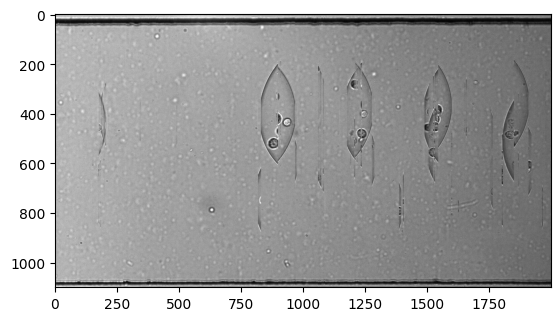

In [74]:
# Background frame by 2D energy
nb_samples = 10 # 30 for satisfying results, very slow
column_energy = []
indexes = []
images_sample = images_mean[0:nb_samples]
for index, image in enumerate(images_sample):
    energy = column_energy_integrated_2d_bis(image, previous=2)
    for col in range(image.shape[1]):
        if index == 0:
            column_energy.append(energy[col])
            indexes.append(0)
        else:
            if column_energy[col] > energy[col]:
                column_energy[col] = energy[col]
                indexes[col] = index
    print(index)

# Background creation
background_energy = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_energy.shape)[0]):
    for j in range((background_energy.shape)[1]):
        background_energy[i][j][:] = images_sample[indexes[j],i,j]

# Energy image
plt.imshow(background_energy)

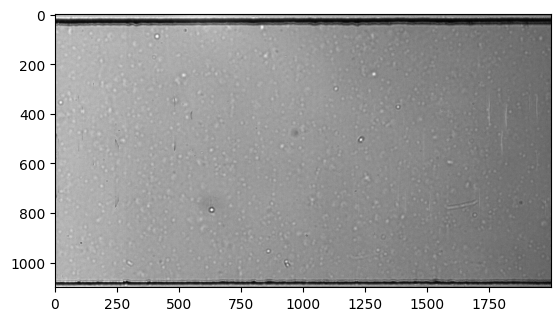

In [60]:
# Background frame by variance
nb_samples = 20
indexes = []
images_nobound = images_mean[:nb_samples,100:-80,:] # Remove the black borders to reduce number of pxl to compute

mean = np.mean(images_nobound)
images_test = (images_nobound - mean)**4
column_mean = np.mean(images_test, axis=1)
indexes = []

for i in range(column_mean.shape[1]):
    indexes.append(list(zip(*np.where(column_mean[:,i]==min(column_mean[:,i])))))

background_variance = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_variance.shape)[0]):
    for j in range((background_variance.shape)[1]):
        background_variance[i][j][:] = images_mean[int(indexes[j][0][0]),i,j]
plt.imshow(background_variance)

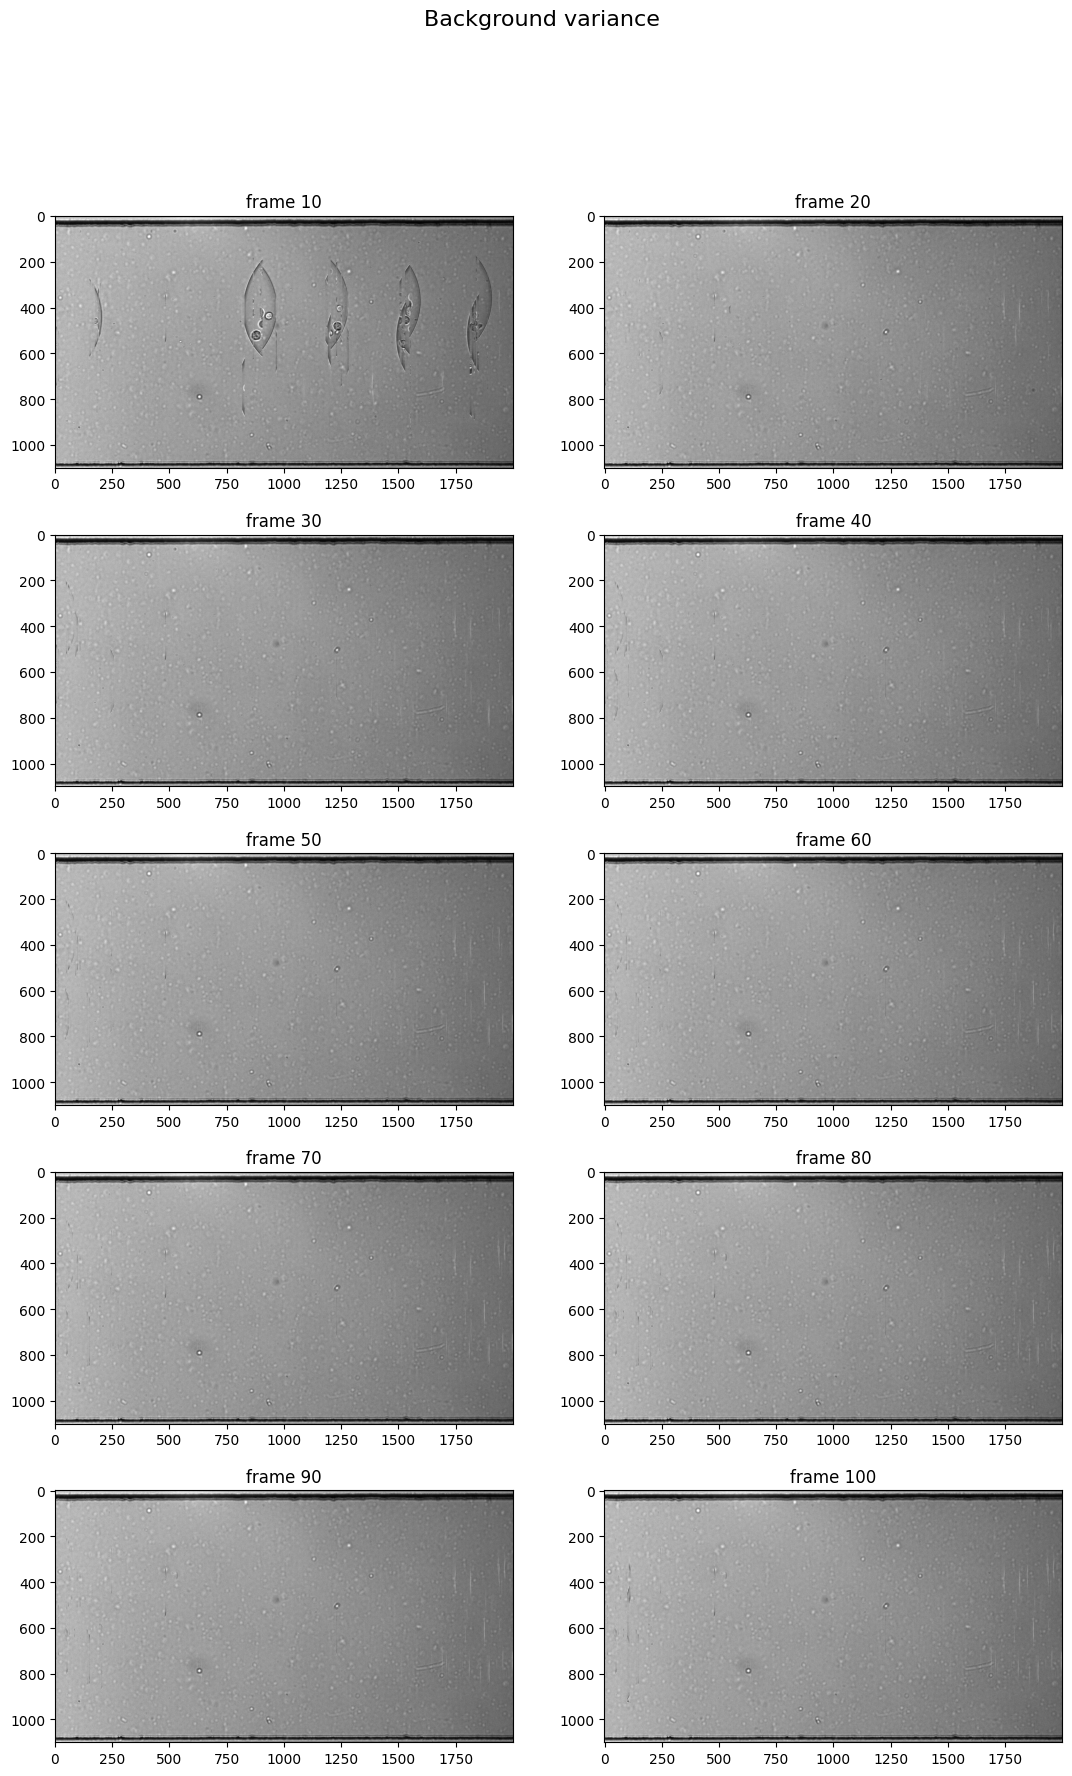

In [61]:
# Plot for variance
fig, axs = plt.subplots(5,2, figsize=(13,20))
fig.suptitle('Background variance', fontsize=16)

for k in range(1,11):
    nb_samples = k*10
    indexes = []
    images_mean = np.mean(images,axis=3)
    images_nobound = images_mean[:nb_samples,100:-80,:]

    mean = np.mean(images_nobound)
    images_test = (images_nobound - mean)**4
    column_mean = np.mean(images_test, axis=1)
    indexes = []

    for i in range(column_mean.shape[1]):
        indexes.append(list(zip(*np.where(column_mean[:,i]==min(column_mean[:,i])))))

    background_variance = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
    for i in range((background_variance.shape)[0]):
        for j in range((background_variance.shape)[1]):
            background_variance[i][j][:] = images_mean[int(indexes[j][0][0]),i,j]

    axs[(k-1)//2,(k-1)%2].imshow(background_variance, cmap='gray')
    axs[(k-1)//2,(k-1)%2].set_title(f'frame {k*10}')
plt.show()

In [62]:
# Full Naive method numpy BRODCAST threshold non normalized

show = False

nb_sample = 100
threshold = 30
back = background[9]

start_time = time.time()
masks = np.zeros((nb_sample, images.shape[1],images.shape[2]))
back = np.broadcast_to(back, (nb_sample, images.shape[1],images.shape[2]))
masks[threshold < abs(images_mean - back)] = 1
execution_time = time.time() - start_time

print("--- Execution time = %s seconds ---" % (execution_time))
print("--- Frame rate %s seconds/frame ---" % ((execution_time)/nb_sample))
print("--- Frame rate %s frame/seconds ---" % (nb_sample/(execution_time)))

if show:
    fig, axs = plt.subplots(5,2, figsize=(15,20))
    for i in range(10):
        axs[i//2,i%2].imshow(masks[i*10], cmap='gray')
        axs[i//2,i%2].set_title(f'frame = {10*i}')


--- Execution time = 2.5131311416625977 seconds ---
--- Frame rate 0.025131311416625977 seconds/frame ---
--- Frame rate 39.79099949947044 frame/seconds ---


In [63]:
# Full Naive method LOOP not parallelized

show = False

nb_sample = 100
threshold = 0.15
back = background[9]
masks = np.zeros((nb_sample, images.shape[1],images.shape[2]))

start_time = time.time()
for i in range(nb_sample):
    im = images_mean[i]
    masks[i] =  (abs(im - back) / np.max(im)) > threshold
execution_time = time.time() - start_time

print("--- Execution time = %s seconds ---" % (execution_time))
print("--- Frame rate %s seconds/frame ---" % ((execution_time)/nb_sample))
print("--- Frame rate %s frame/seconds ---" % (nb_sample/(execution_time)))

if show:
    fig, axs = plt.subplots(5,2, figsize=(15,20))
    for i in range(10):
        axs[i//2,i%2].imshow(masks[i*10], cmap='gray')
        axs[i//2,i%2].set_title(f'frame = {10*i}')

--- Execution time = 1.897895336151123 seconds ---
--- Frame rate 0.01897895336151123 seconds/frame ---
--- Frame rate 52.68994453761455 frame/seconds ---


In [64]:
#Full Naive method LOOP parallelized and final result

show = False

nb_sample = 100
threshold = 0.15
back = background[9]
masks = np.zeros((nb_sample, images.shape[1],images.shape[2]))

def process(i,images_mean,back):
    im = images_mean[i]
    masks[i] =  (abs(im - back) / np.max(im)) > threshold
    return masks[i]

start_time = time.time()  
results = Parallel(n_jobs=-1, prefer="threads")(delayed(process)(i,images_mean,back) for i in range(nb_sample))
execution_time = time.time() - start_time

print("--- Execution time = %s seconds ---" % (execution_time))
print("--- Frame rate %s seconds/frame ---" % ((execution_time)/nb_sample))
print("--- Frame rate %s frame/seconds ---" % (nb_sample/(execution_time)))

if show:
    fig, axs = plt.subplots(5,2, figsize=(15,20))
    for i in range(10):
        axs[i//2,i%2].imshow(masks[i*10], cmap='gray')
        axs[i//2,i%2].set_title(f'frame = {10*i}')

--- Execution time = 1.0302379131317139 seconds ---
--- Frame rate 0.010302379131317138 seconds/frame ---
--- Frame rate 97.06495822505728 frame/seconds ---


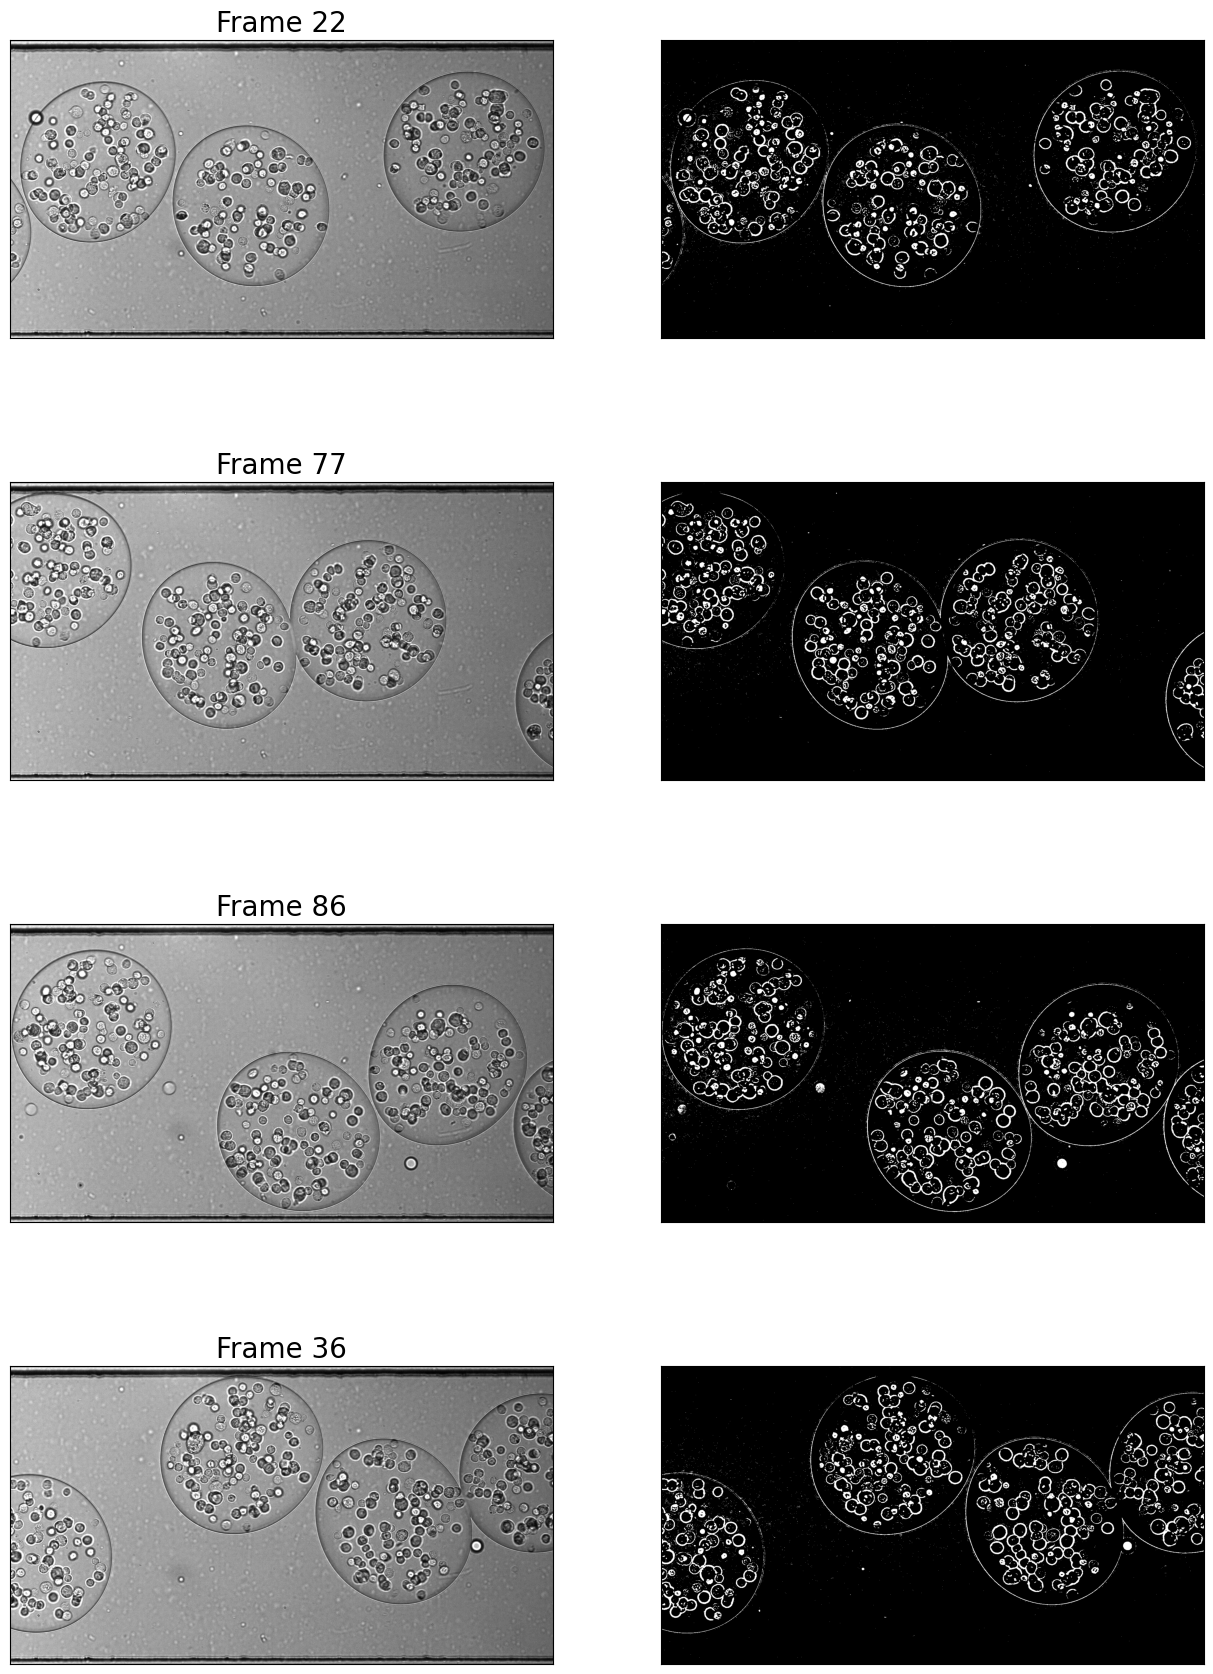

In [65]:
# Treshold with convolution
def back_mean(images):
    images_mean = np.mean(images,axis=3)
    background = np.mean(images_mean[:60],axis=(0))
    return background

threshold = 0.18
background = back_mean(images)
dim = images_mean[0].shape
dim = np.array(dim)
dim = dim/dim[1]
dim = dim*7

n_test = 4
fig, axs = plt.subplots(n_test,2, figsize=(n_test * dim[0],2*(dim[1]+4)))
for i in range(0,n_test):
    frame_number = np.random.randint(0,100)
    im_raw = images_mean[frame_number]
    im_clean = im_raw - background
    im_clean = im_clean/np.max(im_clean)
    im_clean = np.where(im_clean>threshold,255,0)
    conv = np.array([[0,1,0],[1,0,1],[0,1,0]])
    im_conv = signal.convolve2d(im_raw, conv, boundary='symm', mode='same')
    im_conv = signal.convolve2d(im_conv, conv, boundary='symm', mode='same')
    im_clean = np.where(im_conv>0,im_clean,0)
    axs[i,0].imshow(im_raw, cmap='gray')
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
    axs[i,0].set_title(f'Frame {frame_number}', fontsize=20)   

    axs[i,1].imshow(im_clean, cmap='gray')
    axs[i,1].set_xticks([])
    axs[i,1].set_yticks([])
    
plt.show()

### Vibe algorithm based on the paper from M. Van Droogenbroeck and O. Barnich. "ViBe: A Disruptive Method for Background Subtraction." In T. Bouwmans, F. Porikli, B. Hoferlin, and A. Vacavant, editors, Background Modeling and Foreground Detection for Video Surveillance, chapter 7. Chapman and Hall/CRC, June 2014. disponible at the adress: http://www.telecom.ulg.ac.be/publi/publications/mvd/VanDroogenbroeck2014ViBe/

In [66]:
# Vibe algorithm function

def vibe(image, nb_sample, min_match, threshold, samples, learning = True, learning_rate = 0.1, neighboor = True):
    
    result = np.zeros((image.shape[0],image.shape[1]),dtype=np.uint8)
    inter = np.zeros((image.shape[0],image.shape[1],nb_sample),dtype=np.uint8)
    distances = np.tile(image[:, :, np.newaxis], nb_sample)
    distances = np.abs(distances - samples)
    inter[distances < threshold] = 1
    result = np.sum(inter,axis=2)
    mask = result < min_match
    if learning:
        rand = np.random.rand(image.shape[0],image.shape[1])
        place = np.random.randint(0,nb_sample,(image.shape[0],image.shape[1]))
        # update background at location
        update = rand < learning_rate
        samples[update,place[update]] = image[update]
        # updeate background in neighborhood
        if neighboor:
            rand = np.random.rand(image.shape[0],image.shape[1])
            r1 = np.random.randint(-1,2)
            r2 = np.random.randint(-1,2)
            place_neighboor = np.random.randint(0,nb_sample,(image.shape[0],image.shape[1]))
            update_neighborhood = rand < learning_rate
            for i in range(image.shape[0]):
                for j in range(image.shape[1]):
                    if update_neighborhood[i,j]:
                        r1 = np.random.randint(-1,2)
                        if i+r1 < 0 or i+r1 >= image.shape[0]:
                            r1 = 0
                        r2 = np.random.randint(-1,2)
                        if j+r2 < 0 or j+r2 >= image.shape[1]:
                            r2 = 0
                        samples[i+r1,j+r2,place_neighboor[i,j]] = image[i,j]
    
    return mask,samples


0
10
20
30
40
50
60
70
80
90


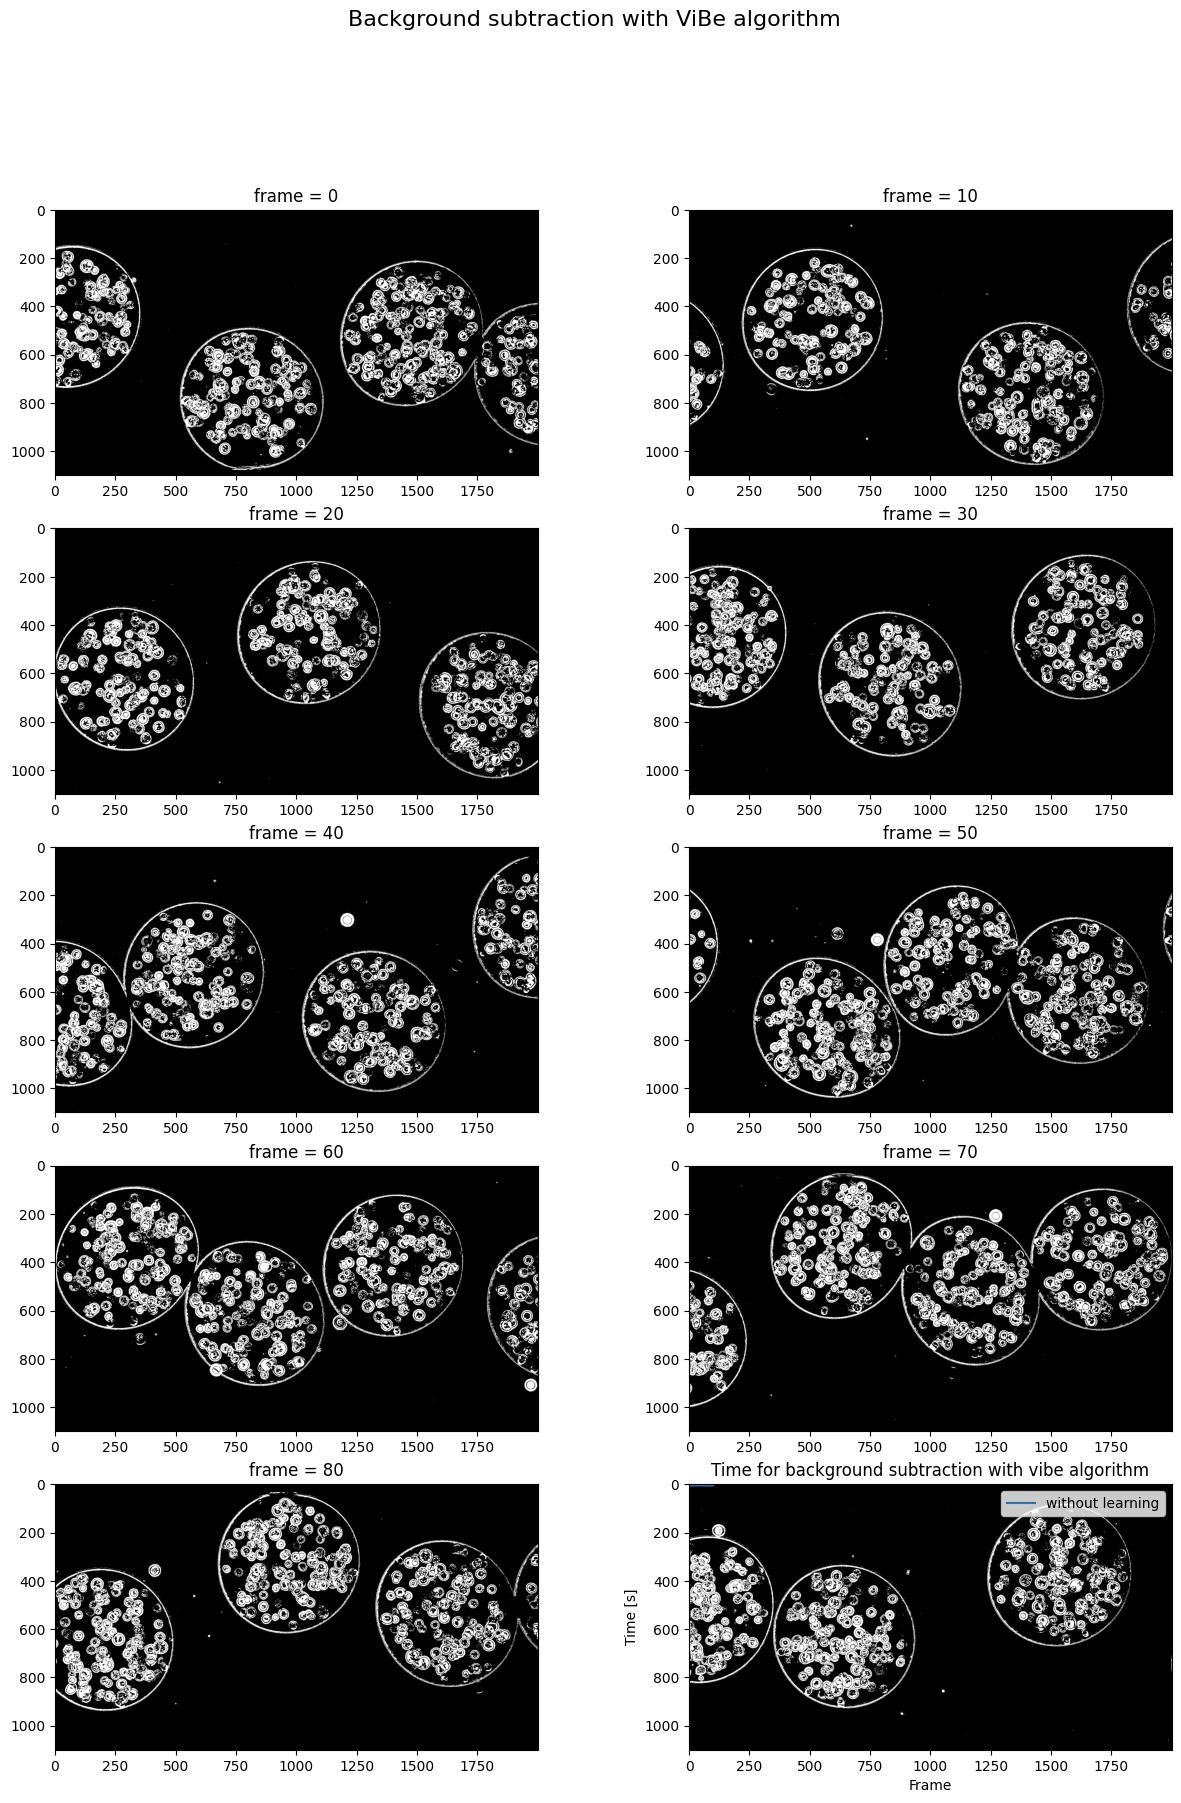

In [71]:
# Vibe algorithm without learning

show = True

nb_sample = 100
mask = np.zeros((nb_sample,images.shape[1],images.shape[2]),dtype=np.uint8)
back = background
samples = np.tile(back[:, :, np.newaxis], nb_sample)
exec_time = np.zeros(100)
for i in range(nb_sample):
    start_time = time.time()
    mask[i], samples = vibe(images_mean[i], nb_sample, 2, 40, samples, learning = False)
    exec_time[i] = time.time() - start_time
    if i%10 == 0:
        print(i)
if show:
    fig, axs = plt.subplots(5,2, figsize=(15,20))
    fig.suptitle('Background subtraction with ViBe algorithm', fontsize=16)
    for i in range(10):
        axs[i//2,i%2].imshow(mask[i*10], cmap='gray')
        axs[i//2,i%2].set_title(f'frame = {10*i}')
plt.plot(exec_time)
plt.legend(['without learning'])
plt.title('Time for background subtraction with vibe algorithm')
plt.xlabel('Frame')
plt.ylabel('Time [s]')
plt.show()

0
10
20
30
40
50
60
70
80
90


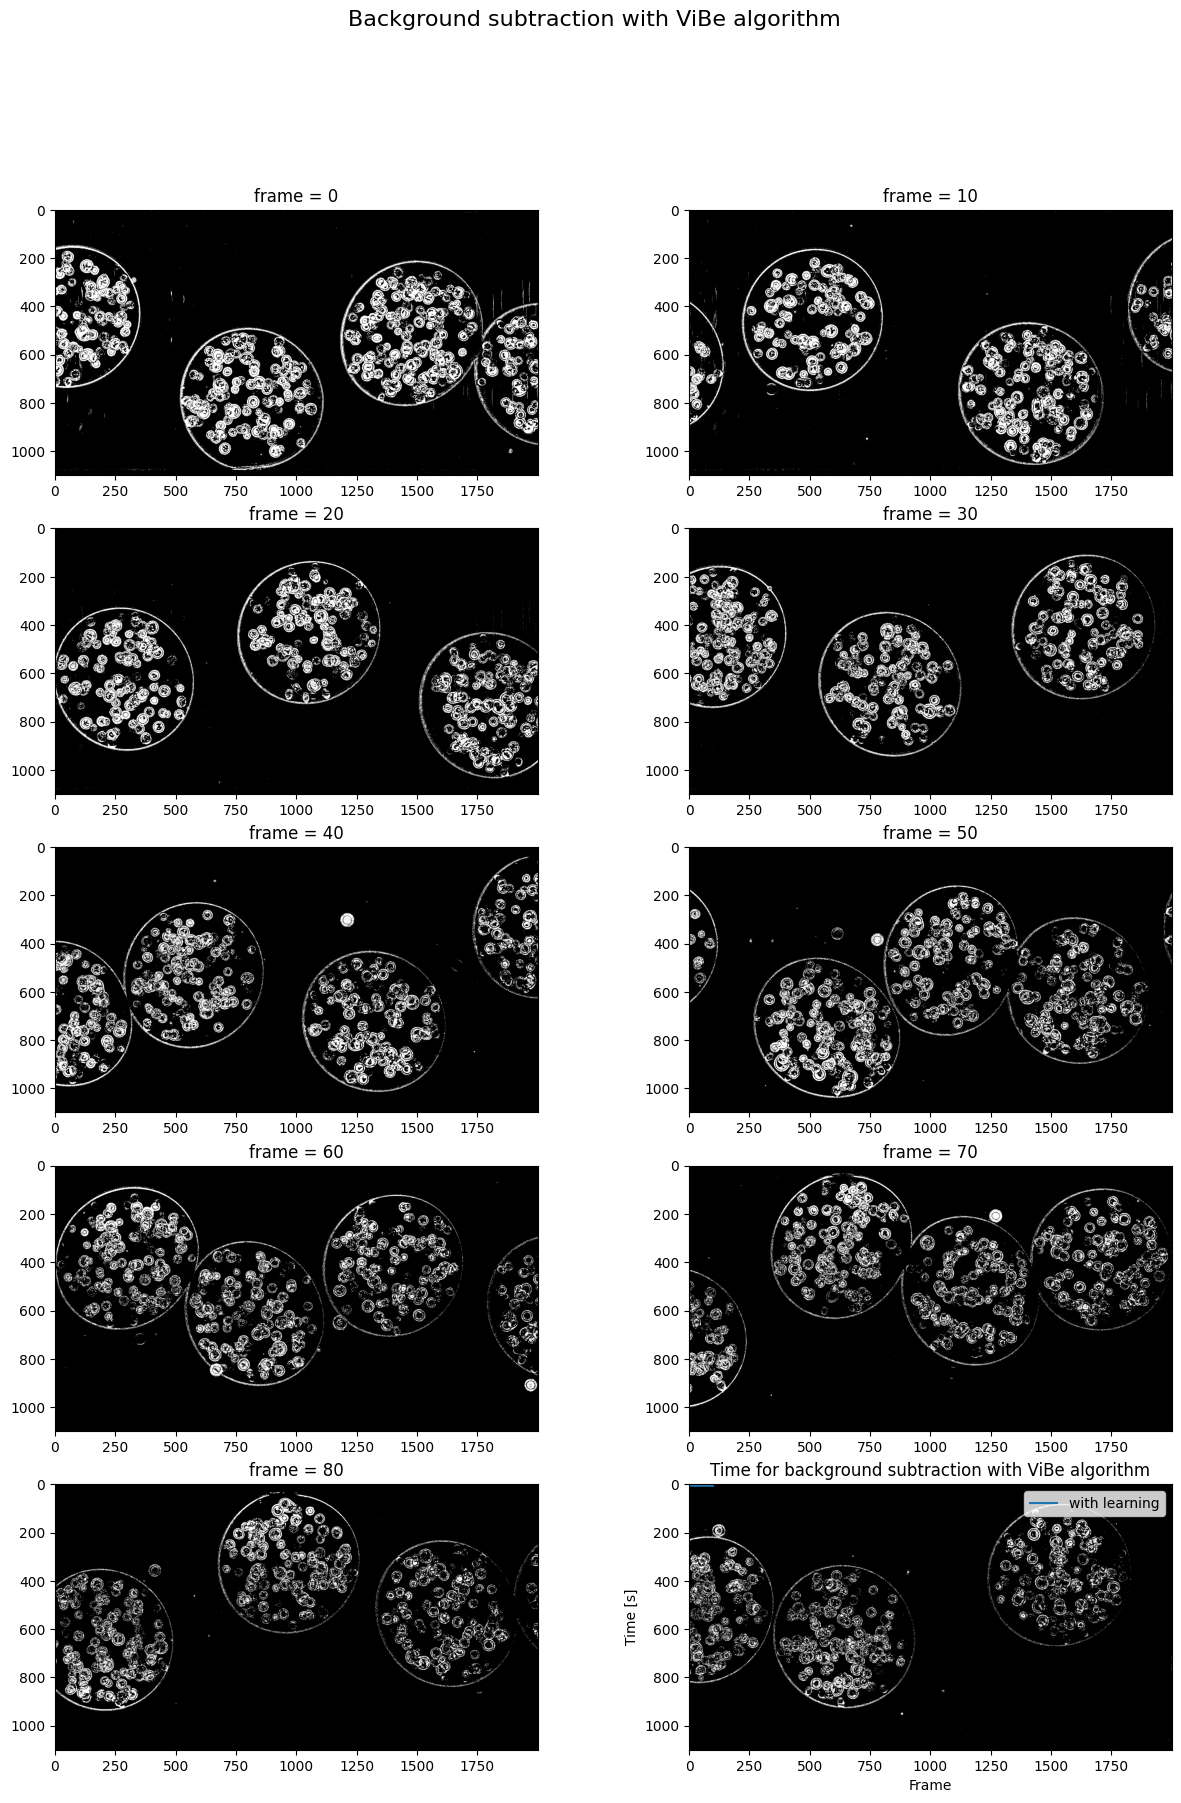

In [72]:
# Vibe algorithm with learning

show = True

nb_sample = 100
mask = np.zeros((nb_sample,images.shape[1],images.shape[2]),dtype=np.uint8)
#back = background[9] # good starting frame (large averaging), learning invisible
back = np.mean(background_variance,axis=2) # imperfect starting frame (variance-like), learning visible
samples = np.tile(back[:, :, np.newaxis], nb_sample)
exec_time_with_learning = np.zeros(100)

for i in range(nb_sample):
    start_time = time.time()
    mask[i], samples = vibe(images_mean[i], nb_sample, 2, 40, samples, learning = True)
    exec_time_with_learning[i] = time.time() - start_time
    if i%10 == 0:
        print(i)
if show:
    fig, axs = plt.subplots(5,2, figsize=(15,20))
    fig.suptitle('Background subtraction with ViBe algorithm', fontsize=16)
    for i in range(10):
        axs[i//2,i%2].imshow(mask[i*10], cmap='gray')
        axs[i//2,i%2].set_title(f'frame = {10*i}')
plt.plot(exec_time_with_learning)
plt.legend(['with learning'])
plt.title('Time for background subtraction with ViBe algorithm')
plt.xlabel('Frame')
plt.ylabel('Time [s]')
plt.show()

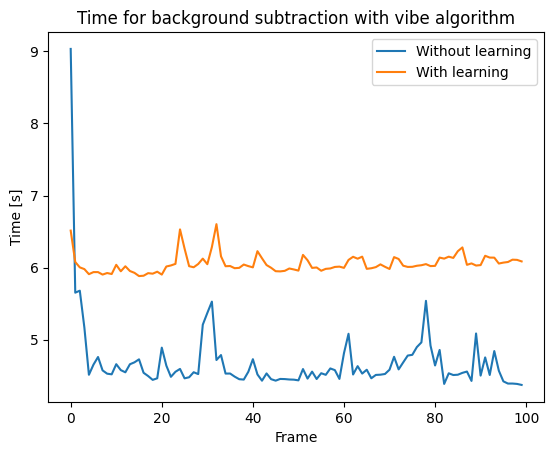

In [73]:
plt.plot(np.arange(100),exec_time,np.arange(100),exec_time_with_learning)
plt.legend(['Without learning','With learning'])
plt.title('Time for background subtraction with vibe algorithm')
plt.xlabel('Frame')
plt.ylabel('Time [s]')
plt.show()

## Final result of the background subtraction task is the one performed in the cell "Full Naive method LOOP parallelized and final result".